# Time Series Forecasting With Neural Networks

In [1]:
import sklearn
import numpy as np
import pandas as pd

from tensorflow import keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional, Dropout, Dense, Input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input

from tensorflow.keras.layers import Input, GRU, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM,GRU, Bidirectional
from keras.models import Sequential
from tensorflow import keras


## Data Preprocessing

In [2]:
# load dataset

path = ''
price_df = pd.read_csv(path + 'prices_extract.csv')
times_series_df = price_df[['Date_full', 'Prix_spot']].set_index('Date_full')
times_series_df

,Prix_spot
Date_full,
2017-10-01 23:30:00,25.77
2017-10-02 00:00:00,22.52
2017-10-02 00:30:00,22.52
2017-10-02 01:00:00,10.64
2017-10-02 01:30:00,10.64
...,...
2022-11-25 12:30:00,273.55
2022-11-25 13:00:00,290.12
2022-11-25 13:30:00,290.12


In [ ]:
# normalizing the entire DataFrame
# times_series_df = (times_series_df-times_series_df.mean())/times_series_df.std()

In [ ]:

# load dataset

path = ''
price_df = pd.read_csv(path + 'prices_extract.csv')
times_series_df = price_df[['Date_full', 'Prix_spot']].set_index('Date_full')
times_series_df
max_price = times_series_df['Prix_spot'].abs().max()

In [ ]:
# apply normalization techniques
for column in times_series_df.columns:
    times_series_df[column] = times_series_df[column]  / times_series_df[column].abs().max()

In [ ]:
# Last YEAR index
price_df.index[price_df['Date_full'] == '2021-11-25 14:30:00'][0]

In [ ]:
# First MONTH of Last year indexes
price_df.index[price_df['Date_full'] == '2021-12-25 14:30:00'][0]

In [ ]:
# First DAY of Last year indexes
price_df.index[price_df['Date_full'] == '2021-11-26 14:30:00'][0]

In [ ]:
max_price = times_series_df['Prix_spot'].max()

In [ ]:
times_series_df

In [ ]:
times_series_df['Prix_spot']

In [ ]:
from sklearn import preprocessing
scaler = sklearn.preprocessing.MinMaxScaler()
# def normalize_data(df):
#     scaler.fit(df.values.reshape(-1,1))
#     df=scaler.transform(df.values.reshape(-1,1))
#     return df

scaler.fit(times_series_df['Prix_spot'].values.reshape(-1,1))
times_series_df=scaler.transform(times_series_df['Prix_spot'].values.reshape(-1,1))


# times_series_df = normalize_data(times_series_df['Prix_spot'])
# times_series_df.shape

how many hours in a year = 8760 

In [ ]:

# load dataset

path = ''
price_df = pd.read_csv(path + 'prices_extract.csv')
times_series_df = price_df[['Date_full', 'Prix_spot']].set_index('Date_full')
times_series_df
max_price = times_series_df['Prix_spot'].abs().max()

In [3]:
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"

import plotly.express as px

def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last days are going to be used in test
    X_test = X_train[72742:]             
    y_test = y_train[72742:]
    
    #2 first 72742 days are going to be used in training
    X_train = X_train[:72742]           
    y_train = y_train[:72742]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (72742 , seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

def plot_predictions(model_name, test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual price')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted price')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized price scale')
    plt.legend()
    plt.show()
    plt.savefig(f'Predictions made by {model_name} model.png')


mean = lambda x: x.mean().flatten() # multiply by the scaling factor if you used a scaler
sd = lambda x: x.std().flatten() 


def conf_int(pred):
    """95% confidence interval"""
    return np.array([mean(pred) - 2*sd(pred), mean(pred) + 2*sd(pred)])



# def plot_predictions_with_CI(model_name, test, predicted, title):
#     fig = go.Figure()
#     band_size = (conf_int(predicted).max() - conf_int(predicted).min())/2
#     plt.figure(figsize=(16,4))
#     # plt.plot(test, color='blue',label='Actual price')
#     # plt.plot(predicted.ravel(), alpha=0.7, color='orange',label='Predicted price')

#     px.line(test) #, name='Actual price')
#     px.line(predicted.ravel()) #, name='Predicted price')
#     # plt.fill_between(np.linspace(0,len(predicted.ravel()),len(predicted.ravel())), (predicted.ravel()-band_size), (predicted.ravel()+band_size), color='b', alpha=.1)
#     # plt.title(title)
#     # plt.xlabel('Time')
#     # plt.ylabel('Price Values')
#     # plt.legend()
#     # plt.show()
#     # plt.savefig(f'Predictions with CI made by {model_name} model.png')


import plotly.express as px
import numpy as np

def plot_predictions_with_CI(model_name, test, predicted, title):
    band_size = (conf_int(predicted).max() - conf_int(predicted).min()) / 2
    
    fig = px.line()
    fig.add_scatter(x=np.arange(len(test)), y=test, mode='lines', name='Actual price', line_color='blue')
    fig.add_scatter(x=np.arange(len(predicted.ravel())), y=predicted.ravel(), mode='lines', name='Predicted price', line_color='orange', opacity=0.7)
    
    fig.update_layout(
        title=title,
        xaxis_title='Time',
        yaxis_title='Price Values',
        showlegend=True
    )
    
    fig.update_layout(
        shapes=[
            dict(
                type="rect",
                xref="x",
                yref="y",
                x0=0,
                y0=predicted.ravel() - band_size,
                x1=len(predicted.ravel()),
                y1=predicted.ravel() + band_size,
                fillcolor="blue",
                opacity=0.1,
                layer="below",
                line_width=0,
            )
        ]
    )
    
    fig.show()
    fig.write_image(f'Predictions with CI made by {model_name} model.png')

    

In [ ]:

from tsmoothie.smoother import *
from tsmoothie.bootstrap import BootstrappingWrapper
import plotly.graph_objects as go
import plotly.express as px

import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"

def smooth_bootstrap_CI(test_data, predictions_dataFrame, the_title="Predictions with CI made by simple CNN model"):

    ### SMOOTH PRED DATA ###

    df_feats_sc = predictions_dataFrame

    smoother = SpectralSmoother(smooth_fraction=0.18, pad_len=12)
    smoother.smooth(df_feats_sc.T)


    plt.figure(figsize=(16,12))

    # for i,c in enumerate(cols):
        
        # plt.subplot(2,2,i+1)
        
    np.random.seed(33)
    bts = BootstrappingWrapper(SpectralSmoother(smooth_fraction=0.18, 
                                                pad_len=12), 

                            bootstrap_type='mbb', 

                            block_length=48
                            
                            )
    #smooth_fraction : float
    """Between 0 and 1. The smoothing strength. A lower value of
    smooth_fraction will result in a smoother curve. It's the proportion
    of frequencies used in the discrete Fourier Transform to smooth
    the curve."""
    #pad_len : int
    """Greater than equal to 1. The length of the padding used at each
    timeseries edge to center the series and obtain better smoothings."""
    #bootstrap_type : str
    """The type of algorithm used to compute the bootstrap.
    Supported types are: none overlapping block bootstrap ('nbb'),
    moving block bootstrap ('mbb'), circular block bootstrap ('cbb'),
    stationary bootstrap ('sb')."""
    #block_length : int
    """The shape of the blocks used to sample from the residuals of the
    smoothing operation and used to bootstrap new samples.
    Must be an integer in [3, timesteps)."""


    bts_samples = bts.sample(df_feats_sc, n_samples=100)

    pd.Series(smoother.smooth_data[0], index=np.array(df_feats_sc.index)).plot(c='green')
    # plt.scatter(df_feats_sc.index, smoother.data, c='black', s=4, label='Pred price')
    
    # # plt.plot(test_data, color='red', label='Actual price')
    # plt.fill_between(df_feats_sc.index, bts_samples.min(0), bts_samples.max(0), alpha=0.3, color='blue', label='CI')
    # plt.title(the_title)
    # plt.legend()

    fig = go.Figure(data=go.Scatter(x=df_feats_sc.index, y=smoother.data))
    # plt.scatter(df_feats_sc.index, smoother.data, c='black', s=4, label='Pred price')

    # plt.plot(test_data, color='red', label='Actual price')
    
    # plt.fill_between(df_feats_sc.index, bts_samples.min(0), bts_samples.max(0), alpha=0.3, color='blue', label='CI')
    fig.add_traces(go.Scatter(x=df_feats_sc.index, y = bts_samples,
                              line = dict(color='rgba(0,0,0,0)'),
                              fill='tonexty', 
                              fillcolor = 'rgba(0,250,0,0.4)' ))
    plt.title(the_title)
    plt.legend()
    fig.show()

In [ ]:


# valid = x
# sarima_preds = y

# fig, ax = plt.subplots(figsize=(15,7))
# # ax.plot(valid, valid['temp'], color='#fc7d0b', label='Valid')
# ax.scatter(valid, sarima_preds)
# ax.fill_between(valid, (valid-band_size), (valid+band_size), color='b', alpha=.1)
# ax.set_title("Predictions w/ 95% Confidence")
# ax.set_xlabel('Date')
# ax.set_ylabel('Temp - Celsius')
# plt.show()



In [ ]:
times_series_df

In [4]:
df = pd.DataFrame(times_series_df, columns = ['Prix_spot'])

## DataFrame Splitting

In [5]:
import numpy as np
#create train, test data
seq_len = 48 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (72742, 48, 1)
y_train.shape =  (72742,)
X_test.shape =  (17373, 48, 1)
y_test.shape =  (17373,)


# Monte Carlo

In [ ]:
y_test

In [ ]:
# y_train_mc

In [ ]:
max_price = times_series_df[column].abs().max()
max_price

In [ ]:
# y_test_mc

In [ ]:

y_test_mc = pd.DataFrame(y_test[-48:], columns = ['Price'])#.multiply(max_price)
# y_test_mc.multiply(max_price).plot()
# y_test_max = scaler.inverse_transform(y_test_mc).max()
# y_test_max

In [ ]:
y_test_mc

In [ ]:
#import necessary packages
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
# from pandas_datareader import data
#download Apple price data into DataFrame
apple = pd.DataFrame(P[:48].flatten()) #data.DataReader('AAPL', 'yahoo',start='1/1/2000')
#calculate the compound annual growth rate (CAGR) which 
#will give us our mean return input (mu) 

# days = (apple.index[-1] - apple.index[0]).days
# cagr = ((((apple['Adj Close'][-1]) / apple['Adj Close'][1])) ** (365.0/days)) - 1

# mu = apple.mean()['Price']/48
mu = apple.mean()[0]/48
print ('mu =',str(round(mu,4)))
#create a series of percentage returns and calculate 
#the annual volatility of returns
y_test_mc['rendements'] = apple.pct_change().fillna(0)
# apple['rendements'] = apple.pct_change()
# apple['rendements'] = apple['rendements'].fillna(0)
vol = y_test_mc['rendements'].std()* math.sqrt(48)
print ("Daily Volatility =",str(round(vol,4)*100)+"%")

In [ ]:
mu

In [ ]:
vol

In [ ]:
px.line(X_train[-1])

In [ ]:
vol/math.sqrt(T)

In [ ]:
list(pd.DataFrame(cnn_predictions[:48])[0])* float(5)

In [ ]:
cnn_predictions[:48][0]

In [ ]:
S = cnn_predictions[:48][0] #starting stock price (i.e. last available real stock price)
T = 48 #Number of trading days
mu = 0.2309 #Return
vol = 0.4259 #Volatility
#choose number of runs to simulate - I have chosen 1000
for i in range(1000):
    #create list of daily returns using random normal distribution
    daily_returns=np.random.normal(mu/T,vol/math.sqrt(T),T)+1
    
    #set starting price and create price series generated by above random daily returns
    price_list = [S]
    
    for x in daily_returns:
        # print(x)
        
        price_list.append( price_list[-1] * x)
    #plot data from each individual run which we will plot at the end
    plt.plot(price_list)
#show the plot of multiple price series created above
plt.show()

In [ ]:
price_list[0]

In [ ]:
#Define Variables
P = cnn_predictions
S = X_train[-1] #apple['Adj Close'][-1] #starting stock price (i.e. last available real stock price)
T = 48 #Number of trading days
mu = mu #Return
vol = vol #Volatility
#create list of daily returns using random normal distribution
daily_returns=np.random.normal((mu/T),vol/math.sqrt(T),T)+1
#set starting price and create price series generated by above random daily returns
price_list = [S]
for x in daily_returns:
    # price_list.append(S[-1]*x)
    price_list.append(P*x)
    
#Generate Plots - price series and histogram of daily returns
plt.plot(X_train[-1])
plt.show()
plt.hist(daily_returns-1, 100) #Note that we run the line plot and histogram separately, not simultaneously.
plt.show()

In [ ]:
(np.random.normal(mu/T,vol/math.sqrt(T),T)+1) * S[-1]

In [ ]:
P = pd.DataFrame(P[:48])
# P[0]

In [ ]:
# P[0] * 20

In [ ]:
len(S)

In [ ]:
S = X_train[-1]
S = list(S.flatten())
S * np.random.normal(mu/T,vol/math.sqrt(T),T)+1

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
#Define Variables
# S = apple['Adj Close'][-1] #starting stock price (i.e. last available real stock price)
# T = 252 #Number of trading days
# mu = 0.2309 #Return
# vol = 0.4259 #Volatility
# price_list = []

#choose number of runs to simulate - I have chosen 1000
for i in range(1000):
    #create list of daily returns using random normal distribution
    # daily_returns= np.random.normal(mu/T,vol/math.sqrt(T),T)+1 #np.random.normal(mu,vol/math.sqrt(T),T)+1
    
    #set starting price and create price series generated by above random daily returns
    price_list = S
    
    for x in daily_returns:
        # P[0]*x
        # price_list.append(P[0]*x)
        price_list.append(S*x)
        # price_list.append(new_sim)
    #plot data from each individual run which we will plot at the end
    plt.plot(price_list)
    # plt.plot(P[0], linewidth=1)
#show the plot of multiple price series created above
plt.show()

In [ ]:
len(price_list)

In [ ]:
plt.plot(price_list)

In [ ]:
(np.random.normal(mu/T,vol/math.sqrt(T),T)+1 )[0] * P[:48]

In [ ]:
max_test= y_test_mc.multiply(max_price).max()

In [ ]:
# y_test_mc['Price'].pct_change().head()

In [ ]:
first_row = y_test_mc.multiply(max_price)['Price'].max()
first_row

In [ ]:
import pandas_montecarlo
# y_test_mc = pd.DataFrame(y_test[-48:], columns = ['Price'])
y_test_mc['Price'] = y_test_mc['Price'].pct_change().fillna(y_test_mc['Price'].min())
mc = y_test_mc['Price'].montecarlo(sims=10000000, bust=-0.8, goal=1) #
# mc = mc.data.multiply(max_price)

In [ ]:
# mc.data['original']

In [ ]:
type(mc.data[mc.data.columns[1]].tolist())

In [ ]:
from difflib import SequenceMatcher

def similar(a, b, th):
    threshold = th
    return (SequenceMatcher(None, a, b).ratio() > threshold)

In [ ]:
# import polars as pl
# # from polars.lazy import *
# import difflib

# # Create an empty DataFrame to store the match counts
# df_list = []

# # Convert df1 to a Polars DataFrame
# df1 = pl.from_pandas(mc.data)

# # Iterate through df1 first
# for cols1 in tqdm.tqdm(range(len(df1.columns))):

#     # Convert df1 column value to a list
#     x = df1[df1.columns[cols1]].to_list()

#     # Iterate through df2 to match df1 column data
#     for cols2 in range(len(df1.columns)):

#         if cols1 != cols2:

#             # Convert df2 column value to a list
#             y = df1[df1.columns[cols2]].to_list()

#             # Iterate and compare each value in df1[col1] with df2[col2]
#             # i==j will result in True or False
#             # sum() will count all True values (i.e., all matched values)

#             # z = x - y
#             # z = sum([abs(i-j) for i, j in zip(x, y)])

#             if difflib.SequenceMatcher(None, x[:24], y[:24]).ratio() >= 0.9:

#                 # Store match count, col 1, col 2 into the list
#                 df_list.append((cols1, cols2))
#                 print(f"cols1={cols1}, cols2={cols2}")

# # Create a new Polars DataFrame from the df_list
# result = pl.DataFrame(df_list, columns=["cols1", "cols2"])


In [ ]:
#create a list to store all the match counts
df_list = []
import difflib
import tqdm
#iterate through df1 first
for cols1 in tqdm.tqdm(range(int(len(mc.data.columns)))) :

    #convert df1 column value to a list
    x = mc.data[mc.data.columns[cols1]].tolist()

    #iterate and compare each value in df1[col1] with df2[col2]
    #i==j will result in True or False
    #sum() will count all True values (i.e., all matched values)

    # z = x - y
    # z = sum([abs(i-j) for i, j in zip(x, y)])

    if similar( x[:24], mc.data['original'][:24], 0.8) == True:


        #store match count, col 1, col 2 into the lsit
        df_list.append((cols1))
        print(f"cols1={cols1}")

        

In [ ]:
import difflib

In [ ]:
similar( df_list[0], df_list[1], 0.1)

In [ ]:
for i in range(len(mc.data.columns)) :
    mc.data[mc.data.columns[i]][0] = 0

In [ ]:
print(mc.data[mc.data.columns[2]][0])

In [ ]:
print(scaler.inverse_transform(mc.data))

In [ ]:
mc.plot(title="Elect Price 1000 Normalized Cumulative Monte Carlo Simulations")  # optional: , figsize=(x, y)


In [ ]:
mc.plot(title="Elect Price 1000 Normalized Cumulative Monte Carlo Simulations")  # optional: , figsize=(x, y)


In [ ]:
max_price

In [ ]:
# print(mc.data.pct_change(-1))

In [ ]:
# mc.data.pct_change(-1).plot()

In [ ]:
max_test['Price']

In [ ]:
len(scaler.inverse_transform(mc.data.cumsum()))

In [ ]:
scaler.inverse_transform(mc.data.cumsum()).reshape(-1).shape

In [ ]:
import warnings
warnings.filterwarnings("ignore")
fig = mc.data.multiply(y_test_max).add(300).plot(title="Elect Price 1000 Monte Carlo Simulations")  # optional: , figsize=(x, y)
fig.write_html("MonteCarlo.html")
fig.show()

In [ ]:
# mc.data.multiply(max_price).add(first_row)

In [ ]:
mc.data.add(300).plot(title="Elect Price Monte Carlo 100 Simulations")  # optional: , figsize=(x, y)

In [ ]:
# mc.data.pct_change(-1).plot()

# CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to good performance since it can see how things are changing over time:

![Convolutional models track alterations throughout time.](images/cnn.png)

In [6]:
from tensorflow import keras

# Define the model architecture
cnn_model = keras.models.Sequential()
cnn_model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
# cnn_model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_model.add(keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(64, activation='relu'))
cnn_model.add(keras.layers.Dense(1))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1472)              0         
                                                                 
 dense (Dense)               (None, 64)                94272     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 94,593
Trainable params: 94,593
Non-trainable params: 0
____________________________________________________

In [7]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='mse')

# Train the model

cnn_model.fit(X_train, y_train, epochs=100, batch_size=1460)
cnn_model.history.history
print(cnn_model.history.history.keys())

Epoch 1/100
50/50 [==============================] - 3s 52ms/step - loss: 389.6259
Epoch 2/100
50/50 [==============================] - 3s 57ms/step - loss: 70.3920
Epoch 3/100
50/50 [==============================] - 3s 59ms/step - loss: 41.4275
Epoch 4/100
50/50 [==============================] - 3s 58ms/step - loss: 31.3686
Epoch 5/100
50/50 [==============================] - 3s 54ms/step - loss: 26.3046
Epoch 6/100
50/50 [==============================] - 3s 56ms/step - loss: 24.2956
Epoch 7/100
50/50 [==============================] - 3s 57ms/step - loss: 23.2154
Epoch 8/100
50/50 [==============================] - 3s 53ms/step - loss: 21.5166
Epoch 9/100
50/50 [==============================] - 3s 55ms/step - loss: 20.2528
Epoch 10/100
50/50 [==============================] - 2s 48ms/step - loss: 19.8521
Epoch 11/100
50/50 [==============================] - 2s 47ms/step - loss: 19.3497
Epoch 12/100
50/50 [==============================] - 2s 48ms/step - loss: 19.6058
Epoch 13/100

In [9]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
cnn_predictions = cnn_model.predict(X_test)

cnn_score = r2_score(y_test,cnn_predictions)
print("R2 Score of CNN model = ", cnn_score)

# plot_predictions_with_CI('CNN', y_test*max_price, cnn_predictions*max_price, "Predictions with CI made by simple CNN model for 1 YEAR")

543/543 [==============================] - 1s 2ms/step
R2 Score of CNN model =  0.9393378467204985


In [23]:
cnn_predictions[:48]

array([[270.1106 ],
       [284.95203],
       [267.95935],
       [289.19897],
       [278.89087],
       [299.13272],
       [290.29797],
       [298.69467],
       [276.7927 ],
       [256.48495],
       [251.78783],
       [240.06079],
       [245.55171],
       [245.82402],
       [254.42494],
       [246.30328],
       [267.40482],
       [270.4065 ],
       [226.14796],
       [213.44572],
       [218.20116],
       [209.22403],
       [209.12727],
       [192.95505],
       [189.71599],
       [192.66342],
       [182.0085 ],
       [193.45108],
       [171.41898],
       [194.69118],
       [175.64568],
       [199.4898 ],
       [209.48654],
       [234.24872],
       [216.30052],
       [223.97256],
       [230.45016],
       [239.46054],
       [232.06992],
       [239.67744],
       [228.73688],
       [226.16397],
       [224.54204],
       [220.89415],
       [214.84494],
       [212.00037],
       [216.71193],
       [223.86072]], dtype=float32)

In [124]:
import numpy as np
import scipy.stats as st

gfg_data = pd.DataFrame(X_train[-48:][-1])
# create 99% confidence interval
our_min = st.t.interval(alpha=0.99,
              df=len(gfg_data)-1,
              loc=np.mean(gfg_data), 
              scale=st.sem(gfg_data))[0]


our_max = st.t.interval(alpha=0.99,
              df=len(gfg_data)-1,
              loc=np.mean(gfg_data), 
              scale=st.sem(gfg_data))[1]


c:\Users\benammaa\MyProjects\Time_series_Prix_electricite\time_series_3_10_fbProphet\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\benammaa\AppData\Local\Temp\ipykernel_31100\4110028424.py:6: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  our_min = st.t.interval(alpha=0.99,
c:\Users\benammaa\MyProjects\Time_series_Prix_electricite\time_series_3_10_fbProphet\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'f

In [125]:
our_min[0]

279.2644072602355

In [126]:
our_max[0]

313.88725940643116

In [64]:
X_test[-1][-1]

array([310.42])

In [66]:
type(cnn_predictions[:4])

numpy.ndarray

In [83]:
cnn_predictions[:4].flatten().shape

(4,)

In [ ]:
type(X_test[-1][-1])

In [116]:
len(np.concatenate((X_train[-1][-1] , cnn_predictions[:48].flatten()), axis=0))

49

In [32]:
cnn_predictions[:48][0]

array([270.1106], dtype=float32)

In [105]:
list(i[0] for i in X_test[0])

[323.39,
 328.77,
 328.77,
 347.16,
 347.16,
 375.0,
 375.0,
 360.65,
 360.65,
 330.0,
 330.0,
 285.37,
 285.37,
 262.87,
 262.87,
 294.04,
 294.04,
 252.87,
 252.87,
 244.58,
 244.58,
 245.82,
 245.82,
 220.93,
 220.93,
 220.28,
 220.28,
 249.48,
 249.48,
 261.82,
 261.82,
 320.0,
 320.0,
 345.0,
 345.0,
 346.37,
 346.37,
 320.5,
 320.5,
 324.65,
 324.65,
 307.17,
 307.17,
 281.1,
 281.1,
 270.0,
 270.0,
 272.8]

In [41]:
for item in [S, our_min, our_max] :
    S = item * 5
    print(S)

[6153.65367881]
[1101.74561311]
[1230.73073576]


In [121]:
cnn_predictions[:49][0]

array([270.1106], dtype=float32)

In [122]:
our_max

array([246.14614715])

100%|██████████| 10000/10000 [00:38<00:00, 261.20it/s]


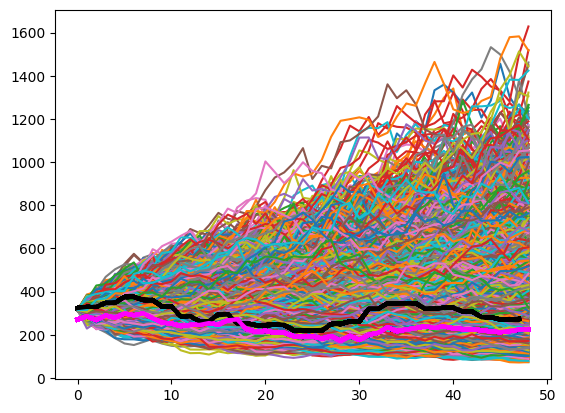

In [128]:
import math
import tqdm
S = our_max# X_train[-1][-1] #starting stock price (i.e. last available real stock price)
T = 48 #Number of trading days
mu = 0.2309 #Return
vol = 0.4259 #Volatility
final_price_list = list()
#choose number of runs to simulate - I have chosen 1000
for i in tqdm.tqdm(range(10000)):
    #create list of daily returns using random normal distribution
    daily_returns=np.random.normal(mu/T,vol/math.sqrt(T),T)+1
    
    #set starting price and create price series generated by above random daily returns
    price_list = [S]
    
    for x in daily_returns:
        # print(x)
        
        price_list.append( price_list[-1] * x)

        if similar(price_list[-1], list(i[0] for i in X_test[0]) , 0.9) == True :
            print("GOAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAL NIGGA !!")



        
    #plot data from each individual run which we will plot at the end
    # final_price_list = [*price_list, *price_list2, *price_list3]
    # plt.plot(price_list)
    plt.plot(price_list)
    # final_price_list = price_list.extend(price_list2)
    # final_price_list = final_price_list.extend(price_list3) 
    plt.plot(X_test[:48][0], linewidth=3, color='black')
    plt.plot(cnn_predictions[:49], linewidth=3, color='magenta')
    final_price_list.append(price_list)
    
#show the plot of multiple price series created above
plt.show()

In [93]:
from difflib import SequenceMatcher

def similar(a, b, th):
    threshold = th
    return (SequenceMatcher(None, a, b).ratio() > threshold)

In [95]:
len(price_list)

49

In [102]:
list(i[0] for i in final_price_list[50])

[323.39,
 313.30188774701736,
 335.5935180040936,
 348.3388465448975,
 391.0458159273804,
 383.9129249514291,
 416.61455949348715,
 417.79651299661043,
 427.4196561597731,
 452.06638752717026,
 449.16658732181276,
 446.33100198570776,
 465.16883728445123,
 503.17145819571584,
 500.7519907568054,
 448.67728531329715,
 461.9171262482171,
 469.6117511331009,
 493.3080350766069,
 478.57976806089056,
 472.3518997668542,
 464.4265182543204,
 471.56462436330315,
 513.2040761602003,
 528.7864617808181,
 482.5758543825909,
 458.3229919549699,
 483.5426315298182,
 535.903101815738,
 539.4484444701101,
 505.02328077420793,
 527.7565041930937,
 565.7249207473619,
 517.4021991321129,
 466.2219518999115,
 448.14703559980916,
 437.2901905181141,
 416.8836034320029,
 373.7889608631707,
 345.66251424665444,
 376.3360972015644,
 372.7069973237125,
 392.4620329508225,
 429.989388672784,
 425.84796440916165,
 396.46279395360455,
 384.9002544115362,
 375.613968306461,
 393.75142427845907]

In [107]:
price_list[-1]

array([275.62645626])

In [106]:
similar(price_list[-1], list(i[0] for i in final_price_list[100]), 0.01)

False

In [ ]:
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

In [ ]:
# from sklearn.metrics import r2_score
# import matplotlib.pyplot as plt
# cnn_predictions = cnn_model.predict(X_test[:48])

# cnn_score = r2_score(y_test[:48],cnn_predictions[:48])
# print("R2 Score of CNN model = ", cnn_score)

# plot_predictions_with_CI('CNN', y_test[:48]*max_price, cnn_predictions[:48]*max_price, "Predictions with CI made by simple CNN model for 1 DAY")

In [ ]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
cnn_predictions = cnn_model.predict(X_test[:(48*30)])

cnn_score = r2_score(y_test[:(48*30)],cnn_predictions[:(48*30)])
print("R2 Score of CNN model = ", cnn_score)


# type(cnn_predictions)
# plot_predictions_with_CI('CNN', y_test[:(48*30)]*max_price, cnn_predictions[:(48*30)]*max_price, "Predictions with CI made by simple CNN model for 1 MONTH")


# cnn_predictions = pd.DataFrame(cnn_predictions, columns = ['Price'])
# smooth_bootstrap_CI(y_test[:(48*30)]*max_price, cnn_predictions[:(48*30)]*max_price, "Predictions with CI made by simple CNN model for 1 MONTH")

In [ ]:
cnn_predictions.flatten()

In [ ]:
X_test[:(48*30)].flatten()

In [ ]:
# cnn_predictions.flatten() - X_test[:(48*30)].flatten()

In [ ]:

X_test_list = []
for i in range(len(X_test[:(48*30)])):
    X_test_list.append(X_test[i][0][0])
    



In [ ]:
# X_test_list[0][0]

In [ ]:
len(list(cnn_predictions.flatten()))

In [ ]:
test_predictions_df1 = pd.DataFrame({'X_test':list(X_test_list), 
                                    'LSTM Prediction':list(cnn_predictions.flatten())})

In [ ]:
resid_list = [max_price * (X_test_list[i]-cnn_predictions[:(48*30)].flatten()[i]) for i in range(len(X_test_list)) ]

In [ ]:
resid_frame = pd.DataFrame({'resid':  resid_list})

In [ ]:
# X_test = pd.DataFrame(X_test[:(48*30)].flatten(), columns = ['Price'])
# type(cnn_predictions)

In [ ]:
px.line(resid_frame)

# fig = px.line()
fig = px.line(resid_frame)
fig.update_layout(
    title='CNN Residual Error for one Month',
    xaxis_title='Time',
    yaxis_title='Price Values',
    showlegend=True
)

In [ ]:
resid_list_day = [max_price * (X_test_list[i]-cnn_predictions[:48].flatten()[i]) for i in range(48) ]

In [ ]:
# px.line(resid_frame)

# fig = px.line()
fig = px.line(resid_list_day)
fig.update_layout(
    title='CNN Residual Errors for one DAY',
    xaxis_title='Time',
    yaxis_title='Price Values',
    showlegend=True
)

In [ ]:
import plotly.express as px

fig = px.histogram(resid_frame, x="resid", marginal="rug", hover_data=resid_frame.columns) #marginal="rug", hover_data=resid_frame.columns
fig.set_title('CNN erros residuals')
fig.show()

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
cnn_predictions = cnn_model.predict(X_test[:(48*30)])
cnn_mae_list = []


for i in range(len(y_test[:(48*30)])):        
    cnn_mae_list.append(max_price * abs((y_test[i] -cnn_predictions[i])) )
    

In [ ]:
# cnn_mae_list

In [ ]:
resid_frame = pd.DataFrame({'resid':  cnn_mae_list})
resid_frame.head(5)

In [ ]:
# import plotly.express as px
# df = px.data.tips()
# fig = px.histogram(resid_frame,  hover_data=resid_frame.columns) #marginal="rug",
# fig.show()

In [ ]:

from tsmoothie.smoother import *
from tsmoothie.bootstrap import BootstrappingWrapper

import plotly.graph_objects as go
import plotly.express as px
def smooth_bootstrap_CI(test_data, predictions_dataFrame, the_title="Predictions with CI made by simple CNN model"):

    ### SMOOTH PRED DATA ###

    df_feats_sc = predictions_dataFrame

    smoother = SpectralSmoother(smooth_fraction=0.18, pad_len=2)
    smoother.smooth(df_feats_sc.T)


    plt.figure(figsize=(16,12))

    # for i,c in enumerate(cols):
        
        # plt.subplot(2,2,i+1)
        
    np.random.seed(33)
    bts = BootstrappingWrapper(SpectralSmoother(smooth_fraction=0.18, 
                                                pad_len=2), 

                            bootstrap_type='mbb', 

                            block_length=6
                            
                            )
    #smooth_fraction : float
    """Between 0 and 1. The smoothing strength. A lower value of
    smooth_fraction will result in a smoother curve. It's the proportion
    of frequencies used in the discrete Fourier Transform to smooth
    the curve."""
    #pad_len : int
    """Greater than equal to 1. The length of the padding used at each
    timeseries edge to center the series and obtain better smoothings."""
    #bootstrap_type : str
    """The type of algorithm used to compute the bootstrap.
    Supported types are: none overlapping block bootstrap ('nbb'),
    moving block bootstrap ('mbb'), circular block bootstrap ('cbb'),
    stationary bootstrap ('sb')."""
    #block_length : int
    """The shape of the blocks used to sample from the residuals of the
    smoothing operation and used to bootstrap new samples.
    Must be an integer in [3, timesteps)."""


    bts_samples = bts.sample(df_feats_sc, n_samples=100)

    pd.Series(smoother.smooth_data[0], index=np.array(df_feats_sc.index)).plot() #(c='green')
    
    # plt.scatter(df_feats_sc.index, smoother.data, c='black', s=4, label='Pred price')
    # # plt.plot(test_data, color='red', label='Actual price')
    # plt.fill_between(df_feats_sc.index, bts_samples.min(0), bts_samples.max(0), alpha=0.3, color='blue', label='CI')
    # plt.title(the_title)
    # plt.legend()

    fig = px.scatter()
    fig.add_scatter(x=df_feats_sc.index, y=pd.Series(smoother.smooth_data[0], index=np.array(df_feats_sc.index)), mode='lines', name='Smoothed Pred Price', line_color='green')
    fig.add_scatter(x=df_feats_sc.index, y=smoother.data, mode='markers', name='Pred price', marker_color='black', marker_size=4)
    fig.add_trace(go.Scatter(x=df_feats_sc.index, y=bts_samples.min(0), mode='lines', fill=None, line_color='blue', name='CI'))
    fig.add_trace(go.Scatter(x=df_feats_sc.index, y=bts_samples.max(0), mode='lines', fill='tonexty', line_color='blue', name='CI'))
    
    fig.update_layout(
        title=the_title,
        xaxis_title='Time',
        yaxis_title='Price Values',
        showlegend=True
    )
    
    fig.show()







In [ ]:
cnn_predictions = pd.DataFrame(cnn_predictions, columns = ['Price'])
type(cnn_predictions)

In [ ]:
smooth_bootstrap_CI(y_test[:48]*max_price, cnn_predictions[:48]*max_price, "Predictions with CI made by simple CNN model for 1 DAY")

In [ ]:
type(cnn_predictions)
cnn_predictions

In [ ]:
cnn_predictions = cnn_model.predict(X_test)
feats_sc = cnn_predictions.flatten()
feats_sc

In [ ]:
X_test.flatten()

In [ ]:
# df_test = pd.DataFrame(times_series_df, columns = ['Prix_spot'])
# df.set_index("First Name", inplace = True)

In [ ]:
import numpy as np
import pandas as pd

my_array = cnn_predictions.flatten()

# feats_sc = np.concatenate(cnn_predictions, axis=1)
# df_predictions = pd.DataFrame(feats_sc, columns = ['Price'])
# df_test = pd.DataFrame(y_test, columns = ['gdTruth'])

dataset = pd.DataFrame({'Price': my_array, 'Test': y_test}, columns=['Price', 'Test']).set_index('Test')
dataset

In [ ]:
# dataset.Price

In [ ]:
df_feats_sc = pd.DataFrame(feats_sc, columns = ['Price'])
type(df_feats_sc)

In [ ]:
# np.array(df_feats_sc.index)

In [ ]:
#Import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

#Plotting Regplot with Seaborn
plt.figure(figsize = (10,8))
# sns.regplot(x=np.array(df_feats_sc.index), y=df_feats_sc, ci   = 99)

sns.regplot(x=np.array(y_test), y=df_feats_sc, ci   = 95)
plt.title('CNN Normalized Cross Plot', fontsize = 20)
plt.xlabel('gdTruth')
plt.ylabel('Predicted')
# plt.title('Square Feet vs. Housing Price', fontsize = 20)
plt.show()

# import plotly.express as px

# # Plotting Regplot with Plotly Express
# fig = px.scatter(x=np.array(y_test), y=df_feats_sc, trendline="ols")
# fig.update_traces(marker=dict(size=6))
# fig.update_layout(
#     title='CNN Normalized Cross Plot',
#     xaxis_title='gdTruth',
#     yaxis_title='Predicted',
#     showlegend=False
# )
# fig.show()

In [ ]:
df_feats_sc*1000

In [ ]:
from tsmoothie.smoother import *
from tsmoothie.bootstrap import BootstrappingWrapper
from tsmoothie.utils_func import create_windows, sim_seasonal_data, sim_randomwalk

In [ ]:
smoother

In [ ]:
len(smoother.smooth_data[0])

In [ ]:
type(df_feats_sc)

In [ ]:
smooth_bootstrap_CI(y_test, df_feats_sc, "Predictions with CI made by simple CNN model for One YEAR")

In [ ]:
import numpy as np
import pandas as pd

my_array = cnn_predictions.flatten()

# feats_sc = np.concatenate(cnn_predictions, axis=1)
# df_predictions = pd.DataFrame(feats_sc, columns = ['Price'])
# df_test = pd.DataFrame(y_test, columns = ['gdTruth'])

dataset = pd.DataFrame({'Price': my_array, 'Test': y_test}, columns=['Price', 'Test']).set_index('Test').sort_index()
dataset

In [ ]:
dataset_full = pd.DataFrame({'Price': my_array}, columns=['Price']).sort_index()
dataset_full

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set_palette(sns.cubehelix_palette(8, light=.6))

# # tips = sns.load_dataset('tips')
# x = 'total_bill'
# y = 'tip'
# cis = [None, 67, 99]
# titles = ['No CI', '67% CI', '99% CI']

# fig, axes = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(7, 10))

# for ci, title, ax in zip(cis, titles, axes):
#     sns.regplot(x    = x,
#                 y    = y,
#                 data = df_feats_sc,
#                 ax   = ax,
#                 ci   = ci).set_title(title)

# plt.tight_layout()
# plt.show()

In [ ]:
def futureForecast(df, col, n_input, n_features, forecast_timeperiod, model):

    x_input = np.array(df[len(df)-n_input:][col])

    temp_input=list(x_input)

    lst_output=[]
    i=0

    while(i < forecast_timeperiod):

        if(len(temp_input) > n_input):

            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape((1, n_input, n_features))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])
            temp_input = temp_input[1:]
            lst_output.append(yhat[0][0])

            i=i+1

        else:
            x_input = x_input.reshape((1, n_input, n_features))
            yhat = model.predict(x_input, verbose=0)
            #print(yhat[0])
            temp_input.append(yhat[0][0])
            lst_output.append(yhat[0][0])

            i=i+1
            
    return lst_output

In [ ]:
# load dataset

path = ''
price_df = pd.read_csv(path + 'prices_extract.csv')
times_series_df = price_df[['Date_full', 'Prix_spot']].set_index('Date_full')[:72742]
times_series_df_for_prediction = price_df[['Date_full', 'Prix_spot']].set_index('Date_full')[:72742].div(max_price)
real_µtimes_series_df = price_df[['Date_full', 'Prix_spot']].set_index('Date_full')[72742:72742+96]
times_series_df.head()

In [ ]:
real_µtimes_series_df

In [ ]:
type(float(max_price))

In [ ]:
n_input = 48
n_features = 1
forecast_timeperiod = 48         # next 10 days
model = cnn_model

forecast_output = futureForecast(times_series_df_for_prediction, 
                                 'Prix_spot', 
                                 n_input, 
                                 n_features, 
                                 forecast_timeperiod, 
                                 model)
# forecast_output *= float(max_price)

In [ ]:
forecast_output = [i * float(max_price) for i in forecast_output]

In [ ]:
last_10_days = times_series_df['Prix_spot'][len(times_series_df) - 48:].tolist()
real_next_10_days = real_µtimes_series_df['Prix_spot'].tolist()
next_10_days = pd.DataFrame(forecast_output, columns = ['FutureForecast'])

In [ ]:
len(next_10_days)

In [ ]:
# plt.figure(figsize = (15,5))

# hist_axis =  len(last_10_days)
# forecast_axis =   hist_axis + len(next_10_days)

# plt.plot(np.arange(0,hist_axis),last_10_days, color = 'blue')
# plt.plot(np.arange(0,hist_axis+48),real_next_10_days, color = 'red')
# plt.plot(np.arange(hist_axis,forecast_axis),next_10_days['FutureForecast'].tolist(), color = 'orange')

# plt.title('CNN Forecast for Next 1 Day')
# plt.xlabel('Hours')
# plt.ylabel('Temperature')

In [ ]:

plt.title('CNN Normalized Cross Plot')
plt.xlabel('gdTruth')
plt.ylabel('Predicted')
plt.scatter(y_test, cnn_predictions)
bisect = np.linspace(0,1,len(y_test))
plt.scatter(bisect, bisect)

# RNN

A recurrent model can learn to use a long history of inputs if it is relevant to the model's predictions. In this case, the model will save internal state for 24 hours before producing a single forecast for the next 30 minutes.

The RNN only has to produce an output at the final time step in this single-shot configuration.

![The RNN builds up state across the input window and makes a single prediction for the following 30 minutes.](images/lstm.png)


In [ ]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

In [ ]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=100, batch_size=1460)

rnn_model.history.history
print(rnn_model.history.history.keys())

In [ ]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

In [ ]:
plot_predictions('RNN', y_test, rnn_predictions, "Predictions made by simple RNN model")

In [ ]:
plot_predictions_with_CI('RNN', y_test*max_price, rnn_predictions*max_price, "Predictions with CI made by simple RNN model")

In [ ]:
df_feats_sc = pd.DataFrame(rnn_predictions, columns = ['Price'])
smooth_bootstrap_CI(rnn_predictions*max_price, "Predictions with CI made by simple RNN model")

In [ ]:
rnn_predictions.max()

In [ ]:

plt.title('RNN Normalized Cross Plot')
plt.xlabel('gdTruth')
plt.ylabel('Predicted')
plt.scatter(y_test, rnn_predictions)
bisect = np.linspace(0,1,len(y_test))
plt.scatter(bisect, bisect)

GRU

A recurrent model can learn to use a long history of inputs if it is relevant to the model's predictions. In this case, the model will save internal state for 24 hours before producing a single forecast for the next 30 minutes.

The GRU only has to produce an output at the final time step in this single-shot configuration.

![The GRU builds up state across the input window and makes a single prediction for the following 30 minutes.](images/lstm.png)


In [ ]:


# Define input shape
input_shape = (X_train.shape[1], 1)

# Input layer
inputs = Input(shape=input_shape)

# First GRU layer
gru = GRU(40, activation="tanh", return_sequences=True)(inputs)
dropout = Dropout(0.2)(gru)

# Second GRU layer
gru = GRU(40, activation="tanh", return_sequences=True)(dropout)
dropout = Dropout(0.2)(gru)

# Third GRU layer
gru = GRU(40, activation="tanh", return_sequences=False)(dropout)
dropout = Dropout(0.2)(gru)

# Output layer
output = Dense(1)(dropout)

# Create the model
gru_model = Model(inputs=inputs, outputs=output)

# Print model summary
gru_model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.001)
gru_model.compile(optimizer=optimizer, loss="mean_squared_error")

In [ ]:
gru_model.compile(optimizer='adam', loss='mean_squared_error')
# gru_model.compile(optimizer="adam",loss="MSE")
gru_model.fit(X_train, y_train, epochs=100, batch_size=1460)

gru_model.history.history
print(gru_model.history.history.keys())

In [ ]:
gru_predictions = gru_model.predict(X_test)

gru_score = r2_score(y_test, gru_predictions)
print("R^2 Score of GRU model = ", gru_score)

plot_predictions('GRU', y_test, gru_predictions, "Predictions made by GRU model")

In [ ]:
plot_predictions_with_CI('GRU', y_test*max_price, gru_predictions*max_price, "Predictions with CI made by GRU model")

In [ ]:

plt.title('GRU Normalized Cross Plot')
plt.xlabel('gdTruth')
plt.ylabel('Predicted')
plt.scatter(y_test, gru_predictions)
bisect = np.linspace(0,1,len(y_test))
plt.scatter(bisect, bisect)

# LSTM

A recurrent model can learn to use a long history of inputs if it is relevant to the model's predictions. In this case, the model will save internal state for 24 hours before producing a single forecast for the next 30 minutes.

The LSTM only has to produce an output at the final time step in this single-shot configuration.

![The LSTM builds up state across the input window and makes a single prediction for the following 30 minutes.](images/lstm.png)


In [ ]:


input_shape = (X_train.shape[1], 1)

inputs = Input(shape=input_shape)

x = LSTM(40, activation="tanh", return_sequences=True)(inputs)
x = Dropout(0.15)(x)
x = LSTM(40, activation="tanh", return_sequences=True)(x)
x = Dropout(0.15)(x)
x = LSTM(40, activation="tanh", return_sequences=False)(x)
x = Dropout(0.15)(x)

outputs = Dense(1)(x)

lstm_model = Model(inputs=inputs, outputs=outputs)
lstm_model.summary()


In [ ]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=100, batch_size=1460)

lstm_model.history.history
print(lstm_model.history.history.keys())

In [ ]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

In [ ]:
plot_predictions('LSTM', y_test, lstm_predictions, "Predictions made by LSTM model")

In [ ]:
plot_predictions_with_CI('LSTM', y_test*max_price, lstm_predictions*max_price, "Predictions with CI made by LSTM model")

In [ ]:

plt.title('LSTM Normalized Cross Plot')
plt.xlabel('gdTruth')
plt.ylabel('Predicted')
plt.scatter(y_test, lstm_predictions)
bisect = np.linspace(0,1,len(y_test))
plt.scatter(bisect, bisect)

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="blue", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()

# Bi-LSTM

A recurrent model can learn to use a long history of inputs if it is relevant to the model's predictions. In this case, the model will save internal state for 24 hours before producing a single forecast for the next 30 minutes.

Bidirectional LSTM model showing the input and output layers. The red arrows represent the backward sequence track and green the forward sequence track.

The Bi-LSTM only has to produce an output at the final time step in this single-shot configuration.

![The Bi-LSTM builds up state across the input window and makes a single prediction for the following 30 minutes.](images/BI-LSTM.png)


In [ ]:


def create_bilstm_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Bidirectional(LSTM(40, activation="tanh", return_sequences=True))(inputs)
    x = Dropout(0.15)(x)
    x = Bidirectional(LSTM(40, activation="tanh", return_sequences=True))(x)
    x = Dropout(0.15)(x)
    x = Bidirectional(LSTM(40, activation="tanh", return_sequences=False))(x)
    x = Dropout(0.15)(x)

    outputs = Dense(1)(x)

    bilstm_model = Model(inputs=inputs, outputs=outputs)
    bilstm_model.summary()

    return bilstm_model

In [ ]:
input_shape = (X_train.shape[1], 1)
bilstm_model = create_bilstm_model(input_shape)

In [ ]:


# Assuming you have a target variable y_train
bilstm_model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])

In [ ]:
bilstm_model.fit(X_train, y_train, epochs=100, batch_size=1460)

bilstm_model.history.history
print(bilstm_model.history.history.keys())

In [ ]:
bilstm_predictions = bilstm_model.predict(X_test)

bilstm_score = r2_score(y_test, bilstm_predictions)
print("R^2 Score of Bi-LSTM model = ", bilstm_score)



In [ ]:
plot_predictions('Bi-LSTM', y_test, bilstm_predictions, "Predictions made by Bi-LSTM model")

In [ ]:
plot_predictions_with_CI('Bi-LSTM', y_test*max_price, bilstm_predictions*max_price, "Predictions with CI made by Bi-LSTM model")

In [ ]:

plt.title('Bi-LSTM Normalized Cross Plot')
plt.xlabel('gdTruth')
plt.ylabel('Predicted')
plt.scatter(y_test, bilstm_predictions)
bisect = np.linspace(0,1,len(y_test))

plt.scatter(bisect, bisect)

# CNN + LSTM

In [ ]:


# Define the model architecture
model_cnn_lstm = keras.models.Sequential()
model_cnn_lstm.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
model_cnn_lstm.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn_lstm.add(keras.layers.MaxPooling1D(pool_size=2))
model_cnn_lstm.add(keras.layers.LSTM(64, return_sequences=True))
model_cnn_lstm.add(Dropout(0.15))
model_cnn_lstm.add(keras.layers.LSTM(64))
model_cnn_lstm.add(Dropout(0.15))
model_cnn_lstm.add(keras.layers.Dense(1))

model_cnn_lstm.summary()



In [ ]:
# Compile the model
model_cnn_lstm.compile(optimizer='adam', loss='mse')

# Train the model
model_cnn_lstm.fit(X_train, y_train, epochs=100, batch_size=1460)

model_cnn_lstm.history.history
print(model_cnn_lstm.history.history.keys())


In [ ]:
cnn_lstm_predictions = model_cnn_lstm.predict(X_test)

cnn_lstm_score = r2_score(y_test,cnn_lstm_predictions)
print("R2 Score of CNN+LSTM model = ", cnn_lstm_score)


plot_predictions('CNN+LSTM', y_test, cnn_lstm_predictions, "Predictions made by simple CNN+LSTM model")


In [ ]:
plot_predictions_with_CI('CNN+LSTM', y_test*max_price, cnn_lstm_predictions*max_price, "Predictions with CI made by CNN+LSTM model")

In [ ]:
bisect = np.linspace(0,1,len(y_test))

In [ ]:

plt.title('CNN+LSTM Normalized Cross Plot')
plt.xlabel('gdTruth')
plt.ylabel('Predicted')
plt.scatter(y_test, cnn_lstm_predictions)
plt.scatter(bisect, bisect)


In [ ]:
#some confidence interval
y=cnn_lstm_predictions
x=y_test
# ci = 1.96 * np.std(y)/np.sqrt(len(x))

# fig, ax = plt.subplots()
# ax.plot(x,y)
# ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

In [ ]:
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(valid.index, valid['temp'], color='#fc7d0b', label='Valid')
ax.scatter(valid.index, sarima_preds)
ax.fill_between(valid.index, (valid['temp']-band_size), (valid['temp']+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Temp - Celsius')
plt.show()

# Models Saving 

In [ ]:
# gru_model.save(f"./logs/model_gru_r2={round(gru_score,4)}.h5")
# cnn_model.save_weights(f"./logs/model_cnn_r2={round(cnn_score,4)}.h5")

# lstm_model.save_weights(f"./logs/model_lstm_r2={round(lstm_score,4)}.h5")
# bilstm_model.save_weights(f"./logs/model_bi_lstm_r2={round(bilstm_score,4)}.h5")


# model_cnn_lstm.save_weights(f"./logs/model_cnn_lstm_r2={round(cnn_lstm_score,4)}.h5")
# rnn_model.save_weights(f"./logs/model_rnn_r2={round(rnn_score,4)}.h5")

In [ ]:
# !dir

In [ ]:
# from keras.models import load_model

# ori_path = 'C:/Users/benammaa/MyProjects/Time_series_Prix_electricite/'
# gru_model = load_model(ori_path + 'logs/model_gru_r2=0.9456.h5')
# cnn_model = load_model(ori_path + 'logs/model_cnn_r2=0.9436.h5')

# lstm_model = load_model(ori_path + 'logs/model_lstm_r2=0.9452.h5')
# bilstm_model = load_model(ori_path + 'logs/model_bi_lstm_r2=0.9459.h5')

# model_cnn_lstm = load_model(ori_path + 'logs/model_cnn_lstm_r2=0.9469.h5')
# rnn_model = load_model(ori_path + 'logs/model_rnn_r2=0.941.h5')

In [ ]:
# from keras.models import load_model

# ori_path = 'C:/Users/benammaa/MyProjects/Time_series_Prix_electricite/'
# # cnn_model = load_model()

# import tensorflow as tf
# from tensorflow import keras
# #...
# myModel = tf.keras.models.load_model(ori_path + 'logs/model_cnn_r2=0.9436.h5')